In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch
from IPython.display import display, HTML
import plotly.express as px
from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

/Users/susierwu/miniconda3/envs/ar6/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from utils.majorghg_modA import *
from utils.majorghg_modB import * 

# A. first run FAIR model, as output parameters of fair will be used as input for calculating d-GWP

## 1. Create FaIR instance

To reproduce an AR6-like run, we want to allow methane lifetime to be affected by all its relevant chemical precursors (NOx, VOCs, etc) so we set the `ch4_method` flag to `Thornhill2021` (see https://docs.fairmodel.net/en/latest/api_reference.html#fair.FAIR for all of the options for initialising `FAIR`).

In [3]:
f = FAIR(ch4_method="Thornhill2021")

## 2. Define time horizon

A lot of analysis uses 2100 as the time horizon, but 2300 is an interesting end point to see the effects of long-term climate change. We'll set 2300 as the last time bound, so the last emissions time point is 2299.5. We could even run to 2500, as the scenarios are defined that far.

In [4]:
f.define_time(1750, 2300, 1)  # start, end, step

## 3. Define scenarios

Since the eight tier 1 & tier 2 SSPs are shipped with RCMIP, and they are quite familiar, we'll use these scenarios. We'll use the `fill_from_rcmip()` function from FaIR, so these have to use the same scenario names that appear in the RCMIP database.

In [5]:
scenarios = ["ssp119", "ssp126", "ssp245", "ssp370", "ssp434", "ssp460", "ssp534-over", "ssp585"]

In [6]:
f.define_scenarios(scenarios)

## 4. Define configs

The constrained dataset contains 1001 ensemble members, and 47 parameters that define the climate response of FaIR. The parameters pertain to `climate_configs` and `species_configs` that produce a wide range of climate responses. We sample from the 11 `climate_configs` parameters that define the [stochastic three-layer energy balance model](https://journals.ametsoc.org/view/journals/clim/33/18/jcliD190589.xml), plus a random seed. Of the other 35 parameters, three vary the behaviour of solar and volcanic forcing and are applied externally. The other 32 vary the behaviour of individual species and override default values of `species_configs` within FaIR (an example being the parameters defining the sensitivity of the carbon cycle feedbacks). Since every species has about 30 configs attached, there's well over a thousand potential parameters that could be modified in FaIR. Outside of the 32 parameters sampled, changing from default values would make little difference, would not be relevant to a particular species, or not be sensible to change.

We'll use `pooch` to retrieve the v1.1 calibration data, and external datasets of solar and volcanic forcing that were pre-prepared for AR6 work.

The name of the `config` axis will be an integer, which relates to the parameter draw from the large prior ensemble used in the calibration and constraining code.

In [7]:
fair_params_1_2_0_obj = pooch.retrieve(
    url = 'https://zenodo.org/record/8399112/files/calibrated_constrained_parameters.csv',
    known_hash = 'md5:de3b83432b9d071efdd1427ad31e9076',
)

In [8]:
df_configs = pd.read_csv(fair_params_1_2_0_obj, index_col=0)
configs = df_configs.index  # this is used as a label for the "config" axis
f.define_configs(configs)

In [9]:
#df_configs.head()

## 5. Define species and properties

We will use FaIR's default list of 63 species. They are often run with default properties that are included in the model code. However, as part of the v1.1 calibration, some defaults are modified, such as the sensitivity of chemical precursors to methane lifetime. Rather than manually overriding this by setting `species_configs`, it is cleaner to modify the defaults in the CSV file that is read in to define the `species` and `properties`. 

In fact, as this only reads in and defines `species` and `properties` (not `species_configs`), the default (no `filename`) argument could be used here, but it is good practice in my opinion to put species, properties and configs in the same file, and to use the same file to read in `properties` and `species_configs`.

If you're following along at home, feel free to insert a new cell after this one and inspect what the `species` and `properties` actually are.

In [10]:
#https://github.com/OMS-NetZero/FAIR/blob/master/examples/data/species_configs_properties_calibration1.2.0.csv 
#saved to 'data/ ... 
species, properties = read_properties(filename='data/species_configs_properties_calibration1.2.0.csv')
f.define_species(species, properties)

In [11]:
#properties

## 6. Modify run options

Not necessary, as we made all of our choices on initialisation (step 1).

## 7. Create input and output xarrays

If this runs without error, the problem is consistently and completely set up: we then just need to add data.

In [12]:
f.allocate()

## 8. Fill in data

### 8a. emissions, solar forcing, and volcanic forcing

We can use the convenience function `fill_from_rcmip()` to fill in the emissions. Remember that not all `species` are things that take emissions, so if you see NaNs below, don't panic.

In [13]:
f.fill_from_rcmip()

In [13]:
#f.emissions

There is an issue with the RCMIP NOx emissions; the units are different for biomass burning emissions (Tg NO/yr) to the other emissions from fossil fuels, industry and agriculture (Tg NO2/yr). v1.1 of the calibration uses the corrected NOx emissions expressed in Tg NO2/yr, so we also have to correct them in FaIR for consistency.

We download the RCMIP emissions file, and pull out the relevant sectors, update the unit, and finally override the correct entry of `f.emissions`.

Notes on the below:

- 46.006 is the molecular weight of NO2 (g/mol).
- 30.006 is the molecular weight of NO (g/mol).
- The final `[:550, None]` is to transfer the data coming in from RCMIP (dimension (750,), a timeseries of annual emissions) into the correct shape for our problem (550, 1001). Since we are looping over the `scenario` dimension and selecting it, and we are selecting NOx from the `species` dimension, these axes are collapsed and we're left with (`timepoints`, `configs`). The RCMIP data starts in 1750 as does our emissions data; if there is a mismatch in the start date, it would be necessary to select the correct slice from the RCMIP `DataFrame` that is loaded in. For a reminder of the dimensioning in FaIR 2.1, see https://docs.fairmodel.net/en/latest/intro.html#dimensionality.

In [14]:
rcmip_emissions_file = pooch.retrieve(
    url="doi:10.5281/zenodo.4589756/rcmip-emissions-annual-means-v5-1-0.csv",
    known_hash="md5:4044106f55ca65b094670e7577eaf9b3",
)
df_emis = pd.read_csv(rcmip_emissions_file)
gfed_sectors = [
    "Emissions|NOx|MAGICC AFOLU|Agricultural Waste Burning",
    "Emissions|NOx|MAGICC AFOLU|Forest Burning",
    "Emissions|NOx|MAGICC AFOLU|Grassland Burning",
    "Emissions|NOx|MAGICC AFOLU|Peat Burning",
]
for scenario in scenarios:
    f.emissions.loc[dict(specie="NOx", scenario=scenario)] = (
        df_emis.loc[
            (df_emis["Scenario"] == scenario)
            & (df_emis["Region"] == "World")
            & (df_emis["Variable"].isin(gfed_sectors)),
            "1750":"2300",
        ]
        .interpolate(axis=1)
        .values.squeeze()
        .sum(axis=0)
        * 46.006
        / 30.006
        + df_emis.loc[
            (df_emis["Scenario"] == scenario)
            & (df_emis["Region"] == "World")
            & (df_emis["Variable"] == "Emissions|NOx|MAGICC AFOLU|Agriculture"),
            "1750":"2300",
        ]
        .interpolate(axis=1)
        .values.squeeze()
        + df_emis.loc[
            (df_emis["Scenario"] == scenario)
            & (df_emis["Region"] == "World")
            & (df_emis["Variable"] == "Emissions|NOx|MAGICC Fossil and Industrial"),
            "1750":"2300",
        ]
        .interpolate(axis=1)
        .values.squeeze()
    )[:550, None]

Now we fetch and fill in the solar and volcanic forcing. As these are forcing-driven time series, if we want to vary the uncertainties in the forcing, this has to happen before FaIR is run (see https://github.com/OMS-NetZero/FAIR/issues/126).

In [15]:
solar_obj = pooch.retrieve(
    url = 'https://raw.githubusercontent.com/chrisroadmap/fair-add-hfc/main/data/solar_erf_timebounds.csv',
    known_hash = 'md5:98f6f4c5309d848fea89803683441acf',
)

In [16]:
volcanic_obj = pooch.retrieve(
    url = 'https://raw.githubusercontent.com/chrisroadmap/fair-calibrate/main/data/forcing/volcanic_ERF_1750-2101_timebounds.csv',
    known_hash = 'md5:c0801f80f70195eb9567dbd70359219d',
)

In [17]:
df_solar = pd.read_csv(solar_obj, index_col="year")
df_volcanic = pd.read_csv(volcanic_obj)

Remembering that everything that is not emissions is on `timebounds`, there is always one more `timebounds` than `timepoints`, so we define arrays of length 551 (1750 to 2300, inclusive).

Volcanic forcing is given monthly, so we average the 12 previous months for each `timebounds` volcanic forcing.

Volcanic forcing here follows the CMIP6 ScenarioMIP convention of a 10 year ramp down to zero from the last year of data (here 2019). Again a little bit of ninja skill with indexing is needed.

In [18]:
solar_forcing = np.zeros(551)
volcanic_forcing = np.zeros(551)
volcanic_forcing[:352] = df_volcanic.erf.values
solar_forcing = df_solar["erf"].loc[1750:2300].values

trend_shape = np.ones(551)
trend_shape[:271] = np.linspace(0, 1, 271)

We then use our calibrated, constrained ensemble to individually scale the volcanic forcing time series, and the solar amplitude and trend:

In [19]:
fill(
    f.forcing,
    volcanic_forcing[:, None, None] * df_configs["fscale_Volcanic"].values.squeeze(),
    specie="Volcanic",
)
fill(
    f.forcing,
    solar_forcing[:, None, None] * df_configs["fscale_solar_amplitude"].values.squeeze()
    + trend_shape[:, None, None] * df_configs["fscale_solar_trend"].values.squeeze(),
    specie="Solar",
)

### 8b. Fill in climate_configs

This is relatively straightforward from the calibrated, constrained dataset.

In [20]:
fill(f.climate_configs["ocean_heat_capacity"], df_configs.loc[:, "clim_c1":"clim_c3"].values)
fill(
    f.climate_configs["ocean_heat_transfer"],
    df_configs.loc[:, "clim_kappa1":"clim_kappa3"].values,
)
fill(f.climate_configs["deep_ocean_efficacy"], df_configs["clim_epsilon"].values.squeeze())
fill(f.climate_configs["gamma_autocorrelation"], df_configs["clim_gamma"].values.squeeze())
fill(f.climate_configs["sigma_eta"], df_configs["clim_sigma_eta"].values.squeeze())
fill(f.climate_configs["sigma_xi"], df_configs["clim_sigma_xi"].values.squeeze())
fill(f.climate_configs["seed"], df_configs["seed"])
fill(f.climate_configs["stochastic_run"], True)
fill(f.climate_configs["use_seed"], True)
fill(f.climate_configs["forcing_4co2"], df_configs["clim_F_4xCO2"])

### 8c. Fill in species_configs

Firstly we want to get the defaults from our new species/properties/configs file

In [21]:
f.fill_species_configs(filename='data/species_configs_properties_calibration1.2.0.csv')

Then, we overwrite the `species_configs` that are varies as part of the probablistic sampling. This makes heavy use of the `fill()` convenience function.

In [22]:
# carbon cycle
fill(f.species_configs["iirf_0"], df_configs["cc_r0"].values.squeeze(), specie="CO2")
fill(f.species_configs["iirf_airborne"], df_configs["cc_rA"].values.squeeze(), specie="CO2")
fill(f.species_configs["iirf_uptake"], df_configs["cc_rU"].values.squeeze(), specie="CO2")
fill(f.species_configs["iirf_temperature"], df_configs["cc_rT"].values.squeeze(), specie="CO2")

# aerosol indirect
fill(f.species_configs["aci_scale"], df_configs["aci_beta"].values.squeeze())
fill(f.species_configs["aci_shape"], df_configs["aci_shape_so2"].values.squeeze(), specie="Sulfur")
fill(f.species_configs["aci_shape"], df_configs["aci_shape_bc"].values.squeeze(), specie="BC")
fill(f.species_configs["aci_shape"], df_configs["aci_shape_oc"].values.squeeze(), specie="OC")

# aerosol direct
for specie in [
    "BC", 
    "CH4", 
    "N2O",
    "NH3", 
    "NOx",
    "OC", 
    "Sulfur", 
    "VOC",
    "Equivalent effective stratospheric chlorine"
]:
    fill(f.species_configs["erfari_radiative_efficiency"], df_configs[f"ari_{specie}"], specie=specie)

# forcing scaling
for specie in [
    "CO2", 
    "CH4", 
    "N2O", 
    "Stratospheric water vapour",
    "Contrails", 
    "Light absorbing particles on snow and ice", 
    "Land use"
]:
    fill(f.species_configs["forcing_scale"], df_configs[f"fscale_{specie}"].values.squeeze(), specie=specie)
# the halogenated gases all take the same scale factor
for specie in [
    "CFC-11",
    "CFC-12",
    "CFC-113",
    "CFC-114",
    "CFC-115",
    "HCFC-22",
    "HCFC-141b",
    "HCFC-142b",
    "CCl4",
    "CHCl3",
    "CH2Cl2",
    "CH3Cl",
    "CH3CCl3",
    "CH3Br",
    "Halon-1211",
    "Halon-1301",
    "Halon-2402",
    "CF4",
    "C2F6",
    "C3F8",
    "c-C4F8",
    "C4F10",
    "C5F12",
    "C6F14",
    "C7F16",
    "C8F18",
    "NF3",
    "SF6",
    "SO2F2",
    "HFC-125",
    "HFC-134a",
    "HFC-143a",
    "HFC-152a",
    "HFC-227ea",
    "HFC-23",
    "HFC-236fa",
    "HFC-245fa",
    "HFC-32",
    "HFC-365mfc",
    "HFC-4310mee",
]:
    fill(f.species_configs["forcing_scale"], df_configs["fscale_minorGHG"].values.squeeze(), specie=specie)

# ozone
for specie in ["CH4", "N2O", "Equivalent effective stratospheric chlorine", "CO", "VOC", "NOx"]:
    fill(f.species_configs["ozone_radiative_efficiency"], df_configs[f"o3_{specie}"], specie=specie)

# initial value of CO2 concentration (but not baseline for forcing calculations)
fill(
    f.species_configs["baseline_concentration"], 
    df_configs["cc_co2_concentration_1750"].values.squeeze(), 
    specie="CO2"
)

### 8d. Initial conditions

It's important these are defined, as they are NaN by default, and it's likely you'll run into problems.

In [24]:
#f.species_configs["baseline_concentration"]
f.species_configs["baseline_concentration"]  #.loc()

<xarray.DataArray 'baseline_concentration' (config: 1001, specie: 64)>
array([[         nan,          nan, 277.62545011, ...,          nan,
                 nan, 344.36275911],
       [         nan,          nan, 279.90913992, ...,          nan,
                 nan, 344.36275911],
       [         nan,          nan, 276.85802526, ...,          nan,
                 nan, 344.36275911],
       ...,
       [         nan,          nan, 276.88099111, ...,          nan,
                 nan, 344.36275911],
       [         nan,          nan, 277.9147795 , ...,          nan,
                 nan, 344.36275911],
       [         nan,          nan, 279.60005188, ...,          nan,
                 nan, 344.36275911]])
Coordinates:
  * config   (config) int64 1230 1715 2658 3898 ... 1497041 1497105 1498424
  * specie   (specie) <U43 'CO2 FFI' ... 'Equivalent effective stratospheric ...

In [25]:
initialise(f.concentration, f.species_configs["baseline_concentration"])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)

## 9. Run

In [26]:
f.run()

Running 8008 projections in parallel: 100%|█| 550/550 [02:57<00:00,  3.09timeste


## 10. Analysis - passed, see example notebook

In [37]:
np.median(f.species_configs["baseline_concentration"].loc[dict(specie='CO2')].values)

278.10033254419835

<font color = "red" > erf from fair is cumulative, not per ppm    </font>

In [39]:
#f.forcing.loc[dict(scenario=scenario, specie = "CO2")].values



 <font color = "red" > alpha_lifetime    </font>

In [27]:
#f.alpha_lifetime.loc[dict(scenario=scenario, specie = "CO2")]
f.alpha_lifetime.loc[dict(scenario=scenario, specie = "N2O")]

<xarray.DataArray (timebounds: 551, config: 1001)>
array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.99999958, 0.99999958, 0.99999958, ..., 0.99999958, 0.99999958,
        0.99999958],
       ...,
       [0.79066585, 0.79066585, 0.79066585, ..., 0.79066585, 0.79066585,
        0.79066585],
       [0.79073366, 0.79073366, 0.79073366, ..., 0.79073366, 0.79073366,
        0.79073366],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * timebounds  (timebounds) float64 1.75e+03 1.751e+03 ... 2.299e+03 2.3e+03
    scenario    <U11 'ssp585'
  * config      (config) int64 1230 1715 2658 3898 ... 1497041 1497105 1498424
    specie      <U43 'N2O'

In [34]:
for scn in ["ssp119", "ssp126", "ssp245", "ssp585" ]:  
    alpha_n2o = f.alpha_lifetime.loc[dict(scenario=scn, specie = "N2O")]
    #alpha_n2o.plot(x='timebounds', y='config')
    #plt.show()
    s1 = alpha_n2o[269].values #this is the scaling factor used in utils module, size 551, 269 is for 2019 = [1750 + 269] 
    print(f"scaling factor for SSP{scn} is {s1} ")
    n2o_alpha = s1[0] * 109 
    print(f"alpha_N2O for SSP{scn} is {n2o_alpha} ")
    print("~~~~~~~")

scaling factor for SSPssp119 is [0.88189074 0.88189074 0.88189074 ... 0.88189074 0.88189074 0.88189074] 
alpha_N2O for SSPssp119 is 96.12609043728075 
~~~~~~~
scaling factor for SSPssp126 is [0.88200312 0.88200312 0.88200312 ... 0.88200312 0.88200312 0.88200312] 
alpha_N2O for SSPssp126 is 96.13833983836078 
~~~~~~~
scaling factor for SSPssp245 is [0.88172657 0.88172657 0.88172657 ... 0.88172657 0.88172657 0.88172657] 
alpha_N2O for SSPssp245 is 96.10819562913822 
~~~~~~~
scaling factor for SSPssp585 is [0.88161744 0.88161744 0.88161744 ... 0.88161744 0.88161744 0.88161744] 
alpha_N2O for SSPssp585 is 96.09630128039713 
~~~~~~~


### testing CH4 /  N2O, 
carbon cycle AGWP why negative in future years? 

In [48]:
# module A: to get fair model output 
nnnn663 = majorghg_get_f(f, scn = "ssp245")          

# module B: calculate metric 
na = majorghg_analysis(f = f, scn = "ssp245")
#print(naa[1].shape) 
#nch4 = na.ch4_analytical2023(alpha_ch4 = nnnn663.call_f_from_fair_gas()[1]["CH4_lifetime"], #index[0,1,2] -> CO2/CH4/N2O

nco2 = na.co2_analytical2023(co2_erf_diff_t = nnnn663.get_co2_1ppm_erf())
nch4 = na.ch4_analytical2023(alpha_ch4 = nnnn663.call_f_from_fair_gas()[1]["CH4_lifetime"], #index[0,1,2] -> CO2/CH4/N2O
                              ch4_erf_diff_t = nnnn663.get_ch4_1ppb_erf())
nn2o = na.n2o_analytical2023(alpha_n2o = nnnn663.call_f_from_fair_gas()[2]["N2O_lifetime"],  
                              ch4_erf_diff_t = nnnn663.get_ch4_1ppb_erf(),
                              n2o_erf_diff_t  = nnnn663.get_n2o_1ppb_erf())

nch4_cc = na.carbon_cycle_adjustment(agtp = nch4[2], rf_co2 = nco2[0], agwp_co2 = nco2[1], agtp_co2 = nco2[2], 
                                iagtp_co2 = nco2[3]) 

nn2o_cc = na.carbon_cycle_adjustment(agtp = nn2o[2], rf_co2 = nco2[0], agwp_co2 = nco2[1], agtp_co2 = nco2[2], 
                                iagtp_co2 = nco2[3]) 

#fnh1, fnh2 = na.final_agwp_gwp_n2o(agwp_n2o = nn2o[1], agwp_co2 = nco2[1], agwp_cc_n2o = nn2o_236[1] )
#fch1, fch2 = na.final_agwp_gwp_ch4 (agwp_ch4 = nch4[1], agwp_co2 = nco2[1], agwp_cc_ch4 = nch4_236[1] )


analyzing for year: 2019


Text(0.5, 1.0, 'carbon cycle adjusted N2O_AGWP_ssp245-2019')

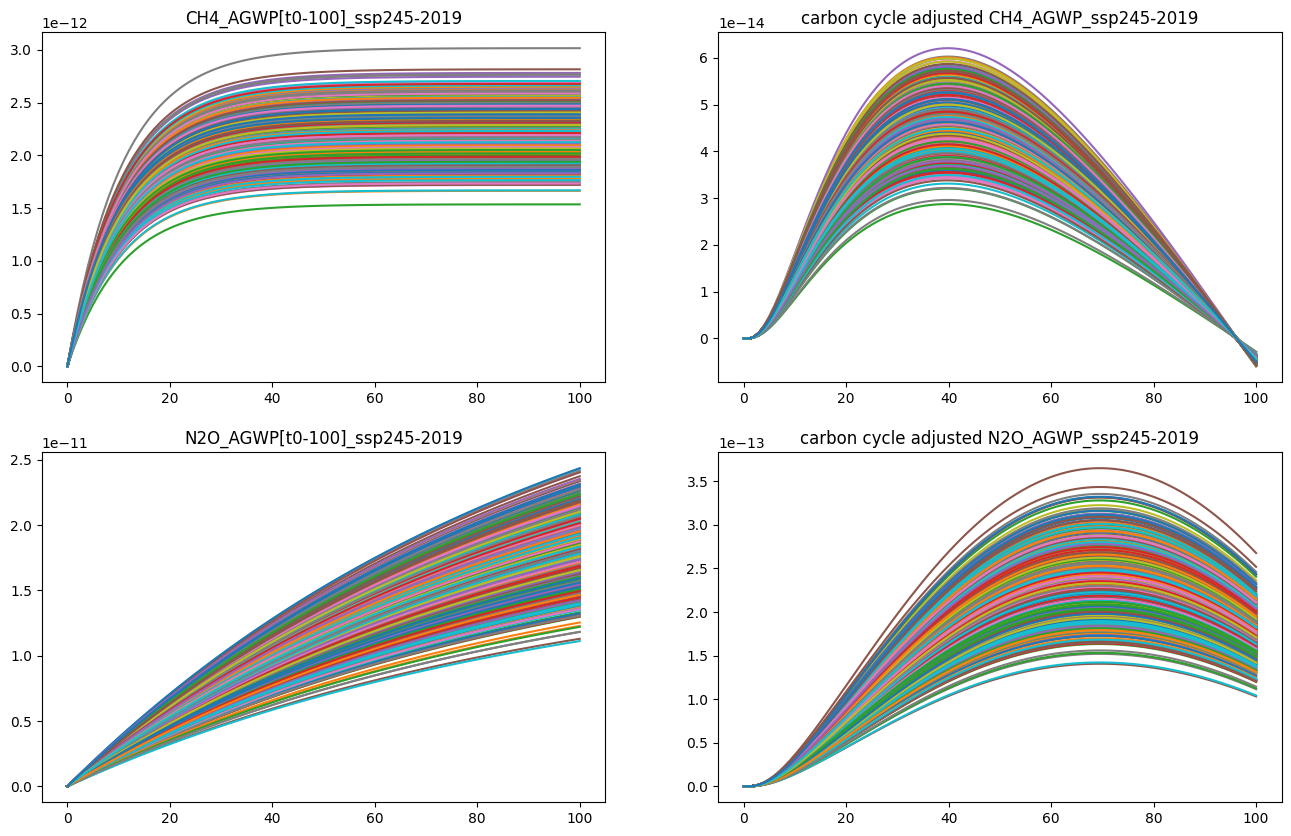

In [52]:
fig, ((ax1, ax2),(ax3, ax4))  = plt.subplots(2,2, figsize=(16, 10), sharey=False)
ax1.plot(nch4[1])
ax1.set_title('CH4_AGWP[t0-100]_ssp245-2019')
ax2.plot(nch4_cc[1])
ax2.set_title('carbon cycle adjusted CH4_AGWP_ssp245-2019')

ax3.plot(nn2o[1])
ax3.set_title('N2O_AGWP[t0-100]_ssp245-2019')
ax4.plot(nn2o_cc[1])
ax4.set_title('carbon cycle adjusted N2O_AGWP_ssp245-2019')

### testing class majorghg_analysis w/h tstep 

In [54]:
# module B: calculate metric 
na = majorghg_analysis(f = f, scn = "ssp245", H_max=20, ts_per_year=5)

nco2 = na.co2_analytical2023(co2_erf_diff_t = nnnn663.get_co2_1ppm_erf())
nch4 = na.ch4_analytical2023(alpha_ch4 = nnnn663.call_f_from_fair_gas()[1]["CH4_lifetime"], #index[0,1,2] -> CO2/CH4/N2O
                              ch4_erf_diff_t = nnnn663.get_ch4_1ppb_erf())
nn2o = na.n2o_analytical2023(alpha_n2o = nnnn663.call_f_from_fair_gas()[2]["N2O_lifetime"],  
                              ch4_erf_diff_t = nnnn663.get_ch4_1ppb_erf(),
                              n2o_erf_diff_t  = nnnn663.get_n2o_1ppb_erf())

nch4_cc = na.carbon_cycle_adjustment(agtp = nch4[2], rf_co2 = nco2[0], agwp_co2 = nco2[1], agtp_co2 = nco2[2], 
                                iagtp_co2 = nco2[3]) 

nn2o_cc = na.carbon_cycle_adjustment(agtp = nn2o[2], rf_co2 = nco2[0], agwp_co2 = nco2[1], agtp_co2 = nco2[2], 
                                iagtp_co2 = nco2[3]) 

fhh1, fhh2 = na.get_finalagwp_gwp_ch4_n2o(agwp_gas = nch4[1], agwp_cc_gas = nch4_cc[1] , agwp_co2 = nco2[1] )
fnn1, fnn2 = na.get_finalagwp_gwp_ch4_n2o(agwp_gas = nn2o[1],  agwp_cc_gas = nn2o_cc[1] , agwp_co2 = nco2[1])
fcc1, fcc2 = na.final_agwp_gwp_co2( agwp_co2 = nco2[1])


analyzing for year: 2019


In [56]:
finalch4_agwp_dcf_gwp = na.get_dcf_finaloutput ("ch4", fhh1, fhh2 )
finaln2o_agwp_dcf_gwp = na.get_dcf_finaloutput ("n2o", fnn1, fnn2 )
finalco2_agwp_dcf_gwp = na.get_dcf_finaloutput ("co2", fcc1, fcc2 )

original AGWP and GWP dims is:  (101, 1001) (101, 1001) Hmax and ts per year is: 20 5
final dims is:  (21, 1001) (21, 1001) (21, 1001)
check dimentions: True
calculated metric saved to output/metrics/agwp_dcf_gwp20_tstep5ch4_ssp245_fair_start1750MY2019.xlsx
original AGWP and GWP dims is:  (101, 1001) (101, 1001) Hmax and ts per year is: 20 5
final dims is:  (21, 1001) (21, 1001) (21, 1001)
check dimentions: True
calculated metric saved to output/metrics/agwp_dcf_gwp20_tstep5n2o_ssp245_fair_start1750MY2019.xlsx
original AGWP and GWP dims is:  (101, 1001) (101, 1001) Hmax and ts per year is: 20 5
final dims is:  (21, 1001) (21, 1001) (21, 1001)
check dimentions: True
calculated metric saved to output/metrics/agwp_dcf_gwp20_tstep5co2_ssp245_fair_start1750MY2019.xlsx


# Final run, 
pretty slow on my slackly laptop, so I test with one SSP, set H_max to 100yr and tsperyear=1

analyzing for year: 2020
original AGWP and GWP dims is:  (101, 1001) (101, 1001) Hmax and ts per year is: 100 1
final dims is:  (101, 1001) (101, 1001) (101, 1001)
check dimentions: True
calculated metric saved to output/metrics/agwp_dcf_gwp100_tstep1CH4_ssp119_fair_start1750MY2020.xlsx
original AGWP and GWP dims is:  (101, 1001) (101, 1001) Hmax and ts per year is: 100 1
final dims is:  (101, 1001) (101, 1001) (101, 1001)
check dimentions: True
calculated metric saved to output/metrics/agwp_dcf_gwp100_tstep1N2O_ssp119_fair_start1750MY2020.xlsx
original AGWP and GWP dims is:  (101, 1001) (101, 1001) Hmax and ts per year is: 100 1
final dims is:  (101, 1001) (101, 1001) (101, 1001)
check dimentions: True
calculated metric saved to output/metrics/agwp_dcf_gwp100_tstep1CO2_ssp119_fair_start1750MY2020.xlsx


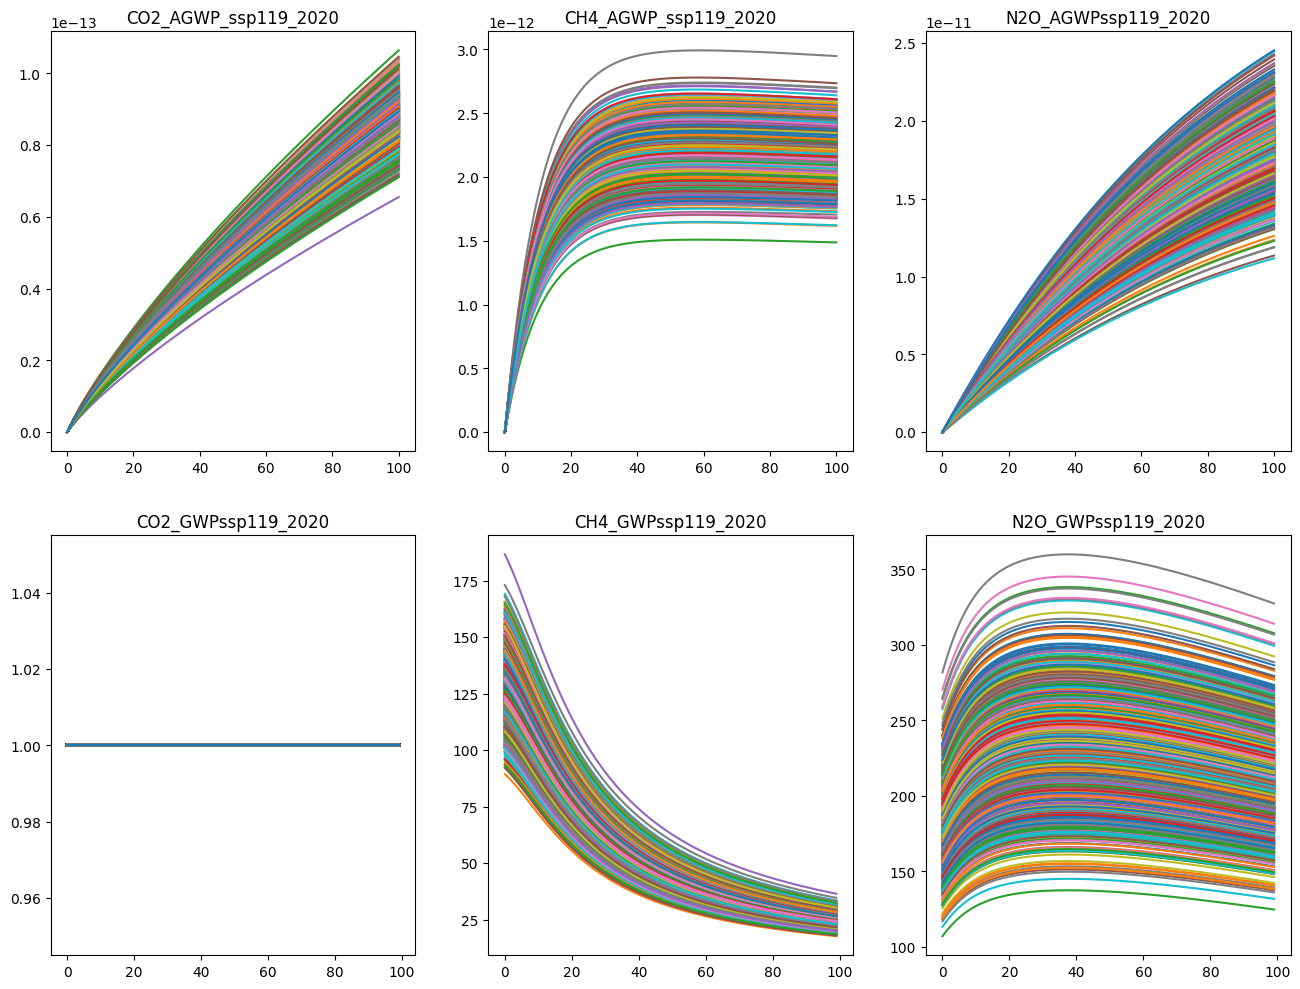

analyzing for year: 2020
original AGWP and GWP dims is:  (101, 1001) (101, 1001) Hmax and ts per year is: 100 1
final dims is:  (101, 1001) (101, 1001) (101, 1001)
check dimentions: True
calculated metric saved to output/metrics/agwp_dcf_gwp100_tstep1CH4_ssp126_fair_start1750MY2020.xlsx
original AGWP and GWP dims is:  (101, 1001) (101, 1001) Hmax and ts per year is: 100 1
final dims is:  (101, 1001) (101, 1001) (101, 1001)
check dimentions: True
calculated metric saved to output/metrics/agwp_dcf_gwp100_tstep1N2O_ssp126_fair_start1750MY2020.xlsx
original AGWP and GWP dims is:  (101, 1001) (101, 1001) Hmax and ts per year is: 100 1
final dims is:  (101, 1001) (101, 1001) (101, 1001)
check dimentions: True
calculated metric saved to output/metrics/agwp_dcf_gwp100_tstep1CO2_ssp126_fair_start1750MY2020.xlsx


<Figure size 640x480 with 0 Axes>

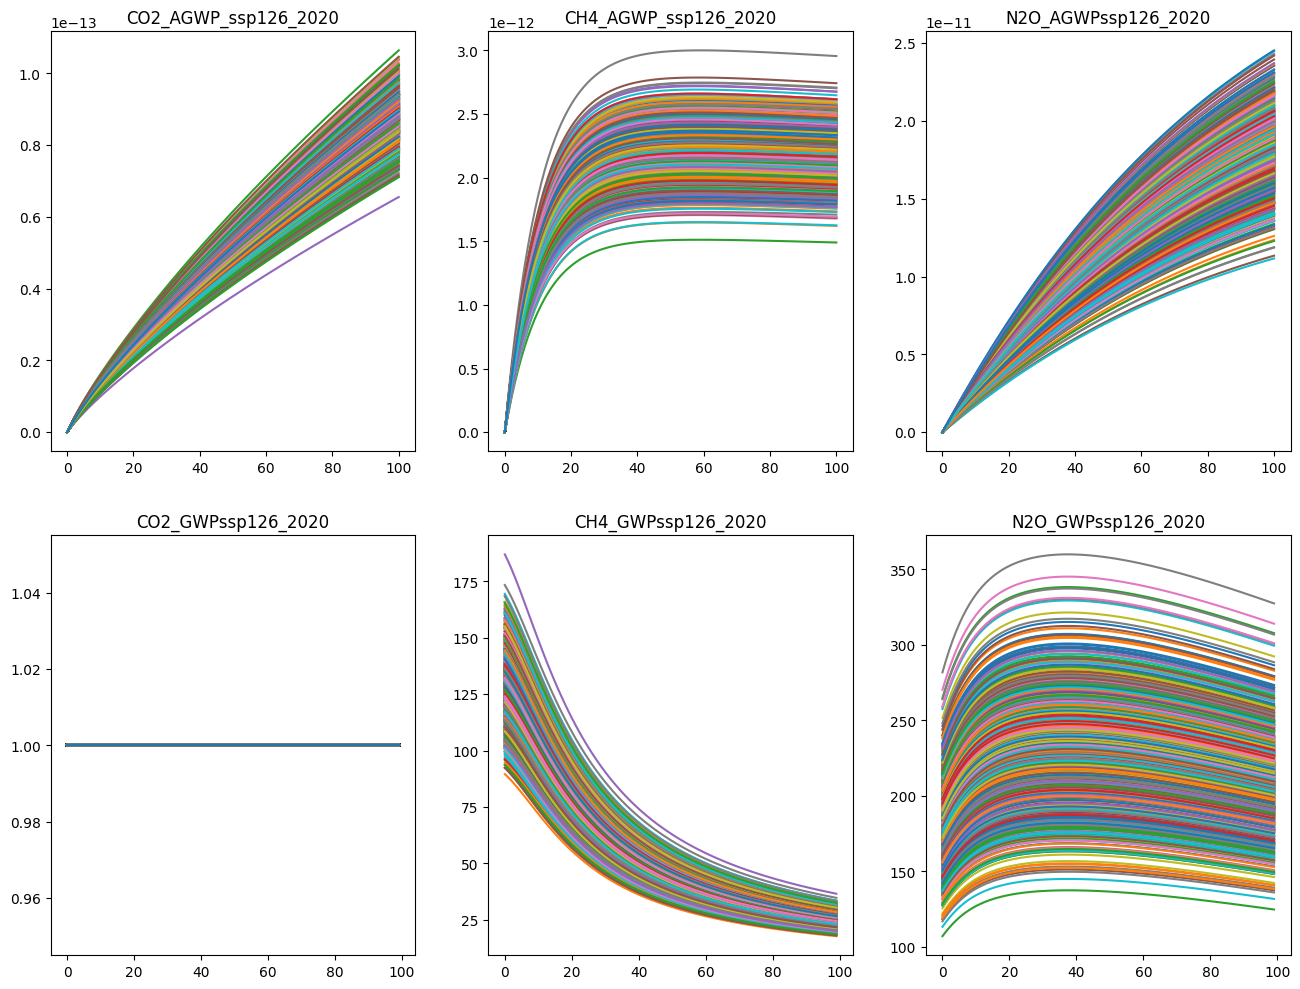

analyzing for year: 2020
original AGWP and GWP dims is:  (101, 1001) (101, 1001) Hmax and ts per year is: 100 1
final dims is:  (101, 1001) (101, 1001) (101, 1001)
check dimentions: True
calculated metric saved to output/metrics/agwp_dcf_gwp100_tstep1CH4_ssp245_fair_start1750MY2020.xlsx
original AGWP and GWP dims is:  (101, 1001) (101, 1001) Hmax and ts per year is: 100 1
final dims is:  (101, 1001) (101, 1001) (101, 1001)
check dimentions: True
calculated metric saved to output/metrics/agwp_dcf_gwp100_tstep1N2O_ssp245_fair_start1750MY2020.xlsx
original AGWP and GWP dims is:  (101, 1001) (101, 1001) Hmax and ts per year is: 100 1
final dims is:  (101, 1001) (101, 1001) (101, 1001)
check dimentions: True
calculated metric saved to output/metrics/agwp_dcf_gwp100_tstep1CO2_ssp245_fair_start1750MY2020.xlsx


<Figure size 640x480 with 0 Axes>

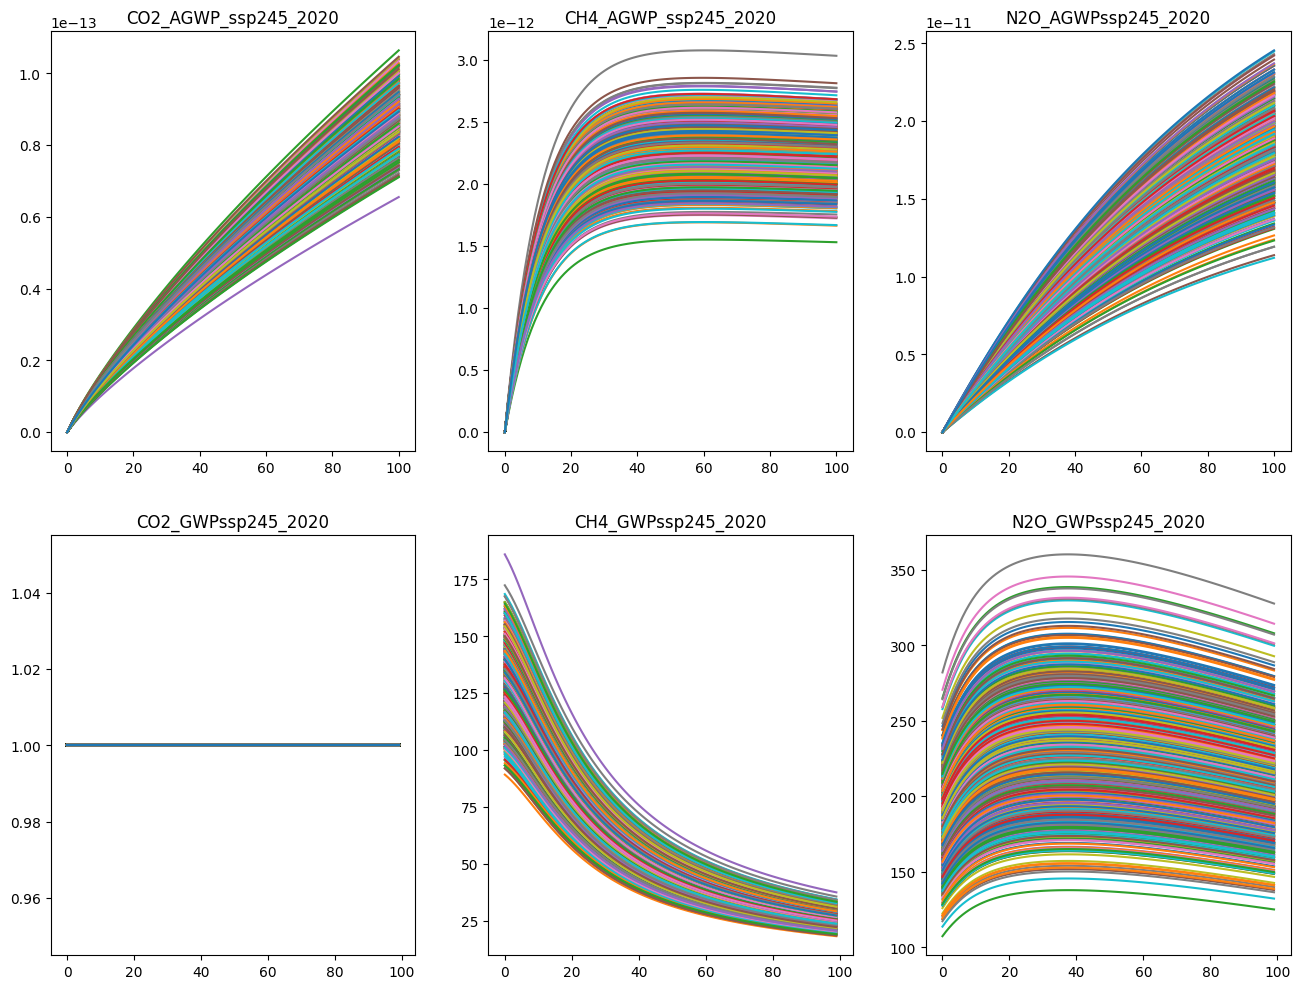

analyzing for year: 2020
original AGWP and GWP dims is:  (101, 1001) (101, 1001) Hmax and ts per year is: 100 1
final dims is:  (101, 1001) (101, 1001) (101, 1001)
check dimentions: True
calculated metric saved to output/metrics/agwp_dcf_gwp100_tstep1CH4_ssp585_fair_start1750MY2020.xlsx
original AGWP and GWP dims is:  (101, 1001) (101, 1001) Hmax and ts per year is: 100 1
final dims is:  (101, 1001) (101, 1001) (101, 1001)
check dimentions: True
calculated metric saved to output/metrics/agwp_dcf_gwp100_tstep1N2O_ssp585_fair_start1750MY2020.xlsx
original AGWP and GWP dims is:  (101, 1001) (101, 1001) Hmax and ts per year is: 100 1
final dims is:  (101, 1001) (101, 1001) (101, 1001)
check dimentions: True
calculated metric saved to output/metrics/agwp_dcf_gwp100_tstep1CO2_ssp585_fair_start1750MY2020.xlsx


<Figure size 640x480 with 0 Axes>

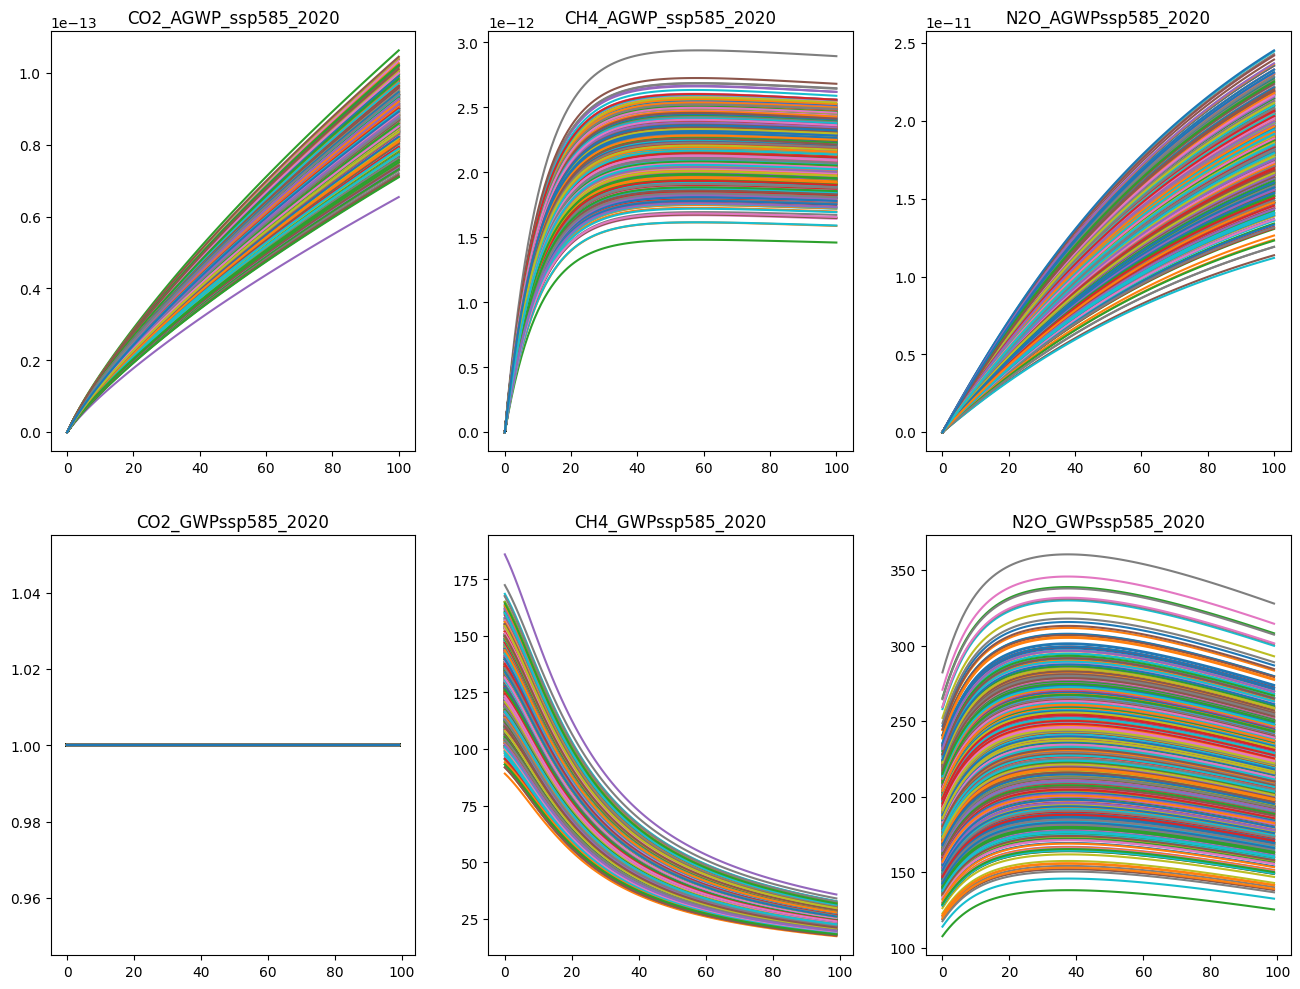

<Figure size 640x480 with 0 Axes>

In [28]:
ssp = ["ssp119", "ssp126", "ssp245", "ssp585"  ] #, "ssp126", "ssp245", "ssp370", "ssp434", "ssp460", "ssp585"

for x in ssp: 
    
    f36 = majorghg_get_f(f = f, H_max=100, ts_per_year = 1, year_index = 270 , scn = x)  # 270 for year 2020, ... 290 for year 2040
    #co2_erf = f36.get_co2_1ppm_erf()
    #ch4_erf = f36.get_ch4_1ppb_erf()
    #n2o_erf = f36.get_n2o_1ppb_erf()
    
    n36 = majorghg_analysis(f = f, H_max=100, ts_per_year = 1, year_index = 270 , scn = x)     
    nco2 = n36.co2_analytical2023(co2_erf_diff_t = f36.get_co2_1ppm_erf() )
    nch4 = n36.ch4_analytical2023(alpha_ch4 = f36.call_f_from_fair_gas()[1]["CH4_lifetime"], #index[0,1,2] -> CO2/CH4/N2O
                                  ch4_erf_diff_t = f36.get_ch4_1ppb_erf())
    nn2o = n36.n2o_analytical2023(alpha_n2o = f36.call_f_from_fair_gas()[2]["N2O_lifetime"],  
                                  ch4_erf_diff_t = f36.get_ch4_1ppb_erf(),
                                  n2o_erf_diff_t  = f36.get_n2o_1ppb_erf() )

    nch4_cc = n36.carbon_cycle_adjustment(agtp = nch4[2], rf_co2 = nco2[0], agwp_co2 = nco2[1], agtp_co2 = nco2[2], 
                                    iagtp_co2 = nco2[3]) 

    nn2o_cc = n36.carbon_cycle_adjustment(agtp = nn2o[2], rf_co2 = nco2[0], agwp_co2 = nco2[1], agtp_co2 = nco2[2], 
                                    iagtp_co2 = nco2[3]) 

    fch41, fch42 = n36.get_finalagwp_gwp_ch4_n2o(agwp_gas = nch4[1], agwp_cc_gas = nch4_cc[1] , agwp_co2 = nco2[1] )
    fn2o1, fn2o2 = n36.get_finalagwp_gwp_ch4_n2o(agwp_gas = nn2o[1],  agwp_cc_gas = nn2o_cc[1] , agwp_co2 = nco2[1])
    fco21, fco22 = n36.final_agwp_gwp_co2( agwp_co2 = nco2[1])
    
    # finalgas_agwp_dcf_gwp: total 6 output: final_agwp, final_agwp_single, final_dcf, final_dcf_single, final_gwp, final_gwp_single
    finalch4_agwp_dcf_gwp = n36.get_dcf_finaloutput ("CH4", fch41, fch42 )
    finaln2o_agwp_dcf_gwp = n36.get_dcf_finaloutput ("N2O", fn2o1, fn2o2  )
    finalco2_agwp_dcf_gwp = n36.get_dcf_finaloutput ("CO2", fco21, fco22 )


    #fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(16, 12), sharey=False)
    fig, ((ax1, ax2, ax3), (ax7, ax8, ax9) ) = plt.subplots(2, 3, figsize=(16, 12), sharey=False)
    ax1.plot(finalco2_agwp_dcf_gwp[0])   #nco2[1]
    ax1.set_title("CO2_AGWP_" + str(x) + "_" +str(1750 + 270))
    ax2.plot(finalch4_agwp_dcf_gwp[0]) #nch4[1]
    ax2.set_title('CH4_AGWP_' + str(x) + "_" +str(1750 + 270))
    ax3.plot(finaln2o_agwp_dcf_gwp[0]) #nn2o[1]
    ax3.set_title('N2O_AGWP' + str(x) + "_" +str(1750 + 270))

    #ax4.plot(finalco2_agwp_dcf_gwp[2])
    #ax4.set_title("CO2_DCF" + str(x) + "_" +str(1750 + 270))
    #ax5.plot(finalch4_agwp_dcf_gwp[2])  
    #ax5.set_title('CH4_DCF' + str(x) + "_" +str(1750 + 270))
    #ax6.plot(finaln2o_agwp_dcf_gwp[2])  
    #ax6.set_title('N2O_DCF' + str(x) + "_" +str(1750 + 270))
    
    #for GWP, delete first YR0, so now shape is (100,1001), don't have 0 at beginning
    ax7.plot(np.delete(finalco2_agwp_dcf_gwp[4],0, axis=0))        
    ax7.set_title("CO2_GWP" + str(x) + "_" +str(1750 + 270))
    ax8.plot(np.delete(finalch4_agwp_dcf_gwp[4],0, axis=0))  
    ax8.set_title('CH4_GWP' + str(x) + "_" +str(1750 + 270))
    ax9.plot(np.delete(finaln2o_agwp_dcf_gwp[4],0, axis=0))  
    ax9.set_title('N2O_GWP' + str(x) + "_" +str(1750 + 270))
    
    plt.show()
    
    fname = "AGWP_DCF_GWP_majorghg_" + str(x) + "_" +str(1750 + 270)
    if not os.path.exists('output/metrics/figures'):
        os.makedirs('output/metrics/figures')
    plt.savefig("output/metrics/figures/" + fname)


### <font color = "red"> testing diff. y_index </font>

In [36]:
ssp = ["ssp119", "ssp126", "ssp245", "ssp585"  ] #, "ssp126", "ssp245", "ssp370", "ssp434", "ssp460", "ssp585"

for x in ssp: 
    for y in [270,290,330]:
    
        f36 = majorghg_get_f(f = f, H_max=100, ts_per_year = 1, year_index = y , scn = x)  # 270 for year 2020, ... 290 for year 2040

        n36 = majorghg_analysis(f = f, H_max=100, ts_per_year = 1, year_index = y , scn = x)     

        nco2 = n36.co2_analytical2023(co2_erf_diff_t = f36.get_co2_1ppm_erf() )
        nch4 = n36.ch4_analytical2023(alpha_ch4 = f36.call_f_from_fair_gas()[1]["CH4_lifetime"], #index[0,1,2] -> CO2/CH4/N2O
                                      ch4_erf_diff_t = f36.get_ch4_1ppb_erf())
        nn2o = n36.n2o_analytical2023(alpha_n2o = f36.call_f_from_fair_gas()[2]["N2O_lifetime"],  
                                      ch4_erf_diff_t = f36.get_ch4_1ppb_erf(),
                                      n2o_erf_diff_t  = f36.get_n2o_1ppb_erf() )

        nch4_cc = n36.carbon_cycle_adjustment(agtp = nch4[2], rf_co2 = nco2[0], agwp_co2 = nco2[1], agtp_co2 = nco2[2], 
                                        iagtp_co2 = nco2[3]) 

        nn2o_cc = n36.carbon_cycle_adjustment(agtp = nn2o[2], rf_co2 = nco2[0], agwp_co2 = nco2[1], agtp_co2 = nco2[2], 
                                        iagtp_co2 = nco2[3]) 

        fch41, fch42 = n36.get_finalagwp_gwp_ch4_n2o(agwp_gas = nch4[1], agwp_cc_gas = nch4_cc[1] , agwp_co2 = nco2[1] )
        fn2o1, fn2o2 = n36.get_finalagwp_gwp_ch4_n2o(agwp_gas = nn2o[1],  agwp_cc_gas = nn2o_cc[1] , agwp_co2 = nco2[1])
        fco21, fco22 = n36.final_agwp_gwp_co2( agwp_co2 = nco2[1])

        # finalgas_agwp_dcf_gwp: total 6 output: final_agwp, final_agwp_single, final_dcf, final_dcf_single, final_gwp, final_gwp_single
        finalch4_agwp_dcf_gwp = n36.get_dcf_finaloutput ("CH4", fch41, fch42 )
        finaln2o_agwp_dcf_gwp = n36.get_dcf_finaloutput ("N2O", fn2o1, fn2o2  )
        finalco2_agwp_dcf_gwp = n36.get_dcf_finaloutput ("CO2", fco21, fco22 )

    


analyzing for year: 2020
original AGWP and GWP dims is:  (101, 1001) (101, 1001) Hmax and ts per year is: 100 1
final dims is:  (101, 1001) (101, 1001) (101, 1001)
check dimentions: True
calculated metric saved to output/metrics/agwp_dcf_gwp100_tstep1CH4_ssp119_fair_start1750MY2020.xlsx
original AGWP and GWP dims is:  (101, 1001) (101, 1001) Hmax and ts per year is: 100 1
final dims is:  (101, 1001) (101, 1001) (101, 1001)
check dimentions: True
calculated metric saved to output/metrics/agwp_dcf_gwp100_tstep1N2O_ssp119_fair_start1750MY2020.xlsx
original AGWP and GWP dims is:  (101, 1001) (101, 1001) Hmax and ts per year is: 100 1
final dims is:  (101, 1001) (101, 1001) (101, 1001)
check dimentions: True
calculated metric saved to output/metrics/agwp_dcf_gwp100_tstep1CO2_ssp119_fair_start1750MY2020.xlsx
analyzing for year: 2040
original AGWP and GWP dims is:  (101, 1001) (101, 1001) Hmax and ts per year is: 100 1
final dims is:  (101, 1001) (101, 1001) (101, 1001)
check dimentions: True

calculated metric saved to output/metrics/agwp_dcf_gwp100_tstep1CH4_ssp585_fair_start1750MY2040.xlsx
original AGWP and GWP dims is:  (101, 1001) (101, 1001) Hmax and ts per year is: 100 1
final dims is:  (101, 1001) (101, 1001) (101, 1001)
check dimentions: True
calculated metric saved to output/metrics/agwp_dcf_gwp100_tstep1N2O_ssp585_fair_start1750MY2040.xlsx
original AGWP and GWP dims is:  (101, 1001) (101, 1001) Hmax and ts per year is: 100 1
final dims is:  (101, 1001) (101, 1001) (101, 1001)
check dimentions: True
calculated metric saved to output/metrics/agwp_dcf_gwp100_tstep1CO2_ssp585_fair_start1750MY2040.xlsx
analyzing for year: 2080
original AGWP and GWP dims is:  (101, 1001) (101, 1001) Hmax and ts per year is: 100 1
final dims is:  (101, 1001) (101, 1001) (101, 1001)
check dimentions: True
calculated metric saved to output/metrics/agwp_dcf_gwp100_tstep1CH4_ssp585_fair_start1750MY2080.xlsx
original AGWP and GWP dims is:  (101, 1001) (101, 1001) Hmax and ts per year is: 100 

## Validation against IPCC AR6 value, and d-DCF / d-GWP reported in Annie's paper
### as detected before, N2O got >20% lower GWP as compared IPCC 
- <font color='red'>N2O GWP500 = 73, run on SSP245 almost half of IPCC_AR6 GWP500</font>
- tracing further, IPCC AR6 has N2O lifetime at 109, here we have a value for all 1001 ensemble = 96.10819563 from fair 

In [29]:
# last SSPx from above for loop
display(HTML(pd.DataFrame(finaln2o_agwp_dcf_gwp[5]).to_html()))

### validate against Annie's model 
https://ciraig.org/index.php/project/dynco2-dynamic-carbon-footprinter/

<font color = "red">if we have annual GWP, can we just simply multiply it by annual inventory in dynamic LCA? </font>

In [59]:
DNYCO2_DCF = pd.read_excel('./Data/validate/crosscheck_DCF_DNYCO2.xlsx', index_col=0) 
#DNYCO2_DCF.head()

<AxesSubplot:xlabel='Year'>

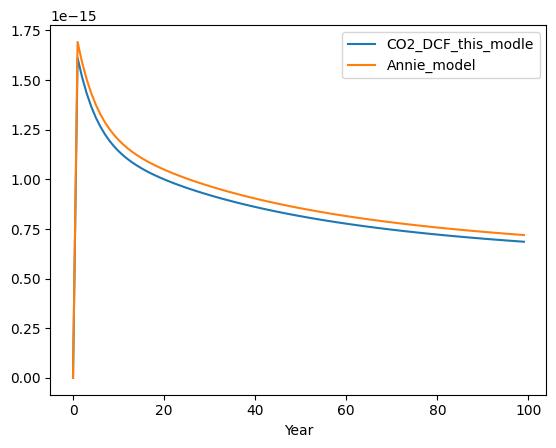

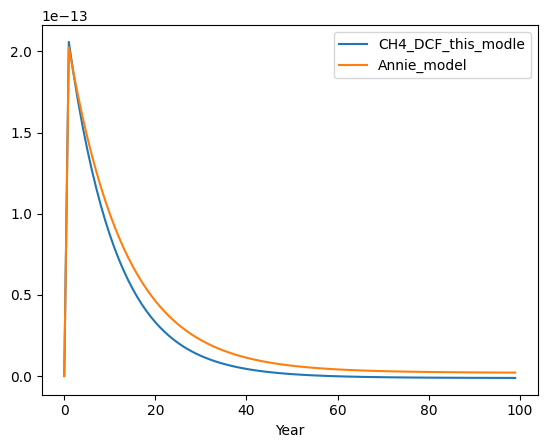

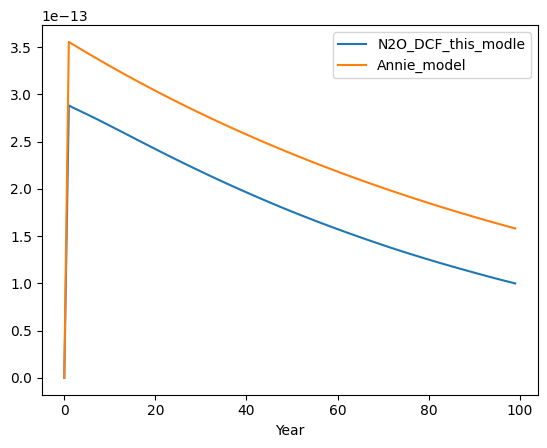

In [60]:
CO2_DCF_diff = pd.DataFrame ({'CO2_DCF_this_modle': finalco2_agwp_dcf_gwp[3][0:100] , 'Annie_model': DNYCO2_DCF['CO2'][0:100]}) 
CH4_DCF_diff = pd.DataFrame ({'CH4_DCF_this_modle': finalch4_agwp_dcf_gwp[3][0:100] , 'Annie_model': DNYCO2_DCF['CH4'][0:100]}) 
N2O_DCF_diff = pd.DataFrame ({'N2O_DCF_this_modle': finaln2o_agwp_dcf_gwp[3][0:100] , 'Annie_model': DNYCO2_DCF['N2O'][0:100]}) 

CO2_DCF_diff.plot()
CH4_DCF_diff.plot()
N2O_DCF_diff.plot()

(0.0, 1.0)

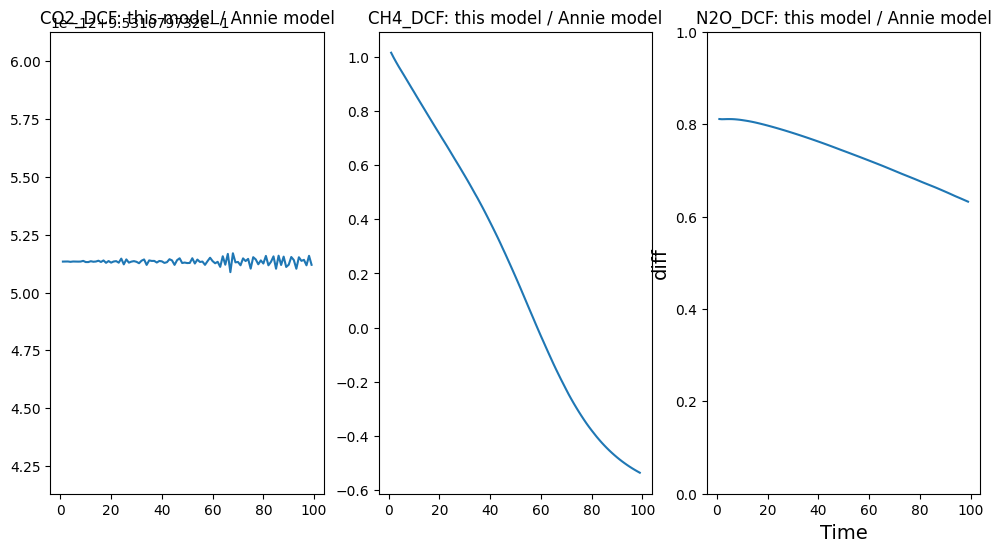

In [62]:
# absolute ratio difference
CO2_DCF_diff = (finalco2_agwp_dcf_gwp[3][0:100] / DNYCO2_DCF['CO2'][0:100])
CH4_DCF_diff = (finalch4_agwp_dcf_gwp[3][0:100] / DNYCO2_DCF['CH4'][0:100])
N2O_DCF_diff = (finaln2o_agwp_dcf_gwp[3][0:100] / DNYCO2_DCF['N2O'][0:100])

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(12, 6), sharey=False)
ax1.plot(CO2_DCF_diff)    
ax1.set_title("CO2_DCF: this model / Annie model")
ax2.plot(CH4_DCF_diff)
ax2.set_title("CH4_DCF: this model / Annie model")
ax3.plot(N2O_DCF_diff)
ax3.set_title("N2O_DCF: this model / Annie model")

plt.xlabel('Time', size=14)
plt.ylabel('diff', size=14)
plt.ylim(0,1)

# explore diff scenario
### AGWP for majorghg among different SSP for year 2040

In [63]:
ssp = ["ssp119", "ssp126", "ssp245", "ssp370", "ssp434", "ssp460", "ssp585"]
agwp_co2_allssp_2040, agwp_ch4_allssp_2040, agwp_n2o_allssp_2040 = [], [], []
for x in ssp: 
    
    f36 = majorghg_get_f(f = f, H_max=200, ts_per_year = 1, year_index = 290 , scn = x)  # 270 for year 2020, ... 290 for year 2040
    n36 = majorghg_analysis(f = f, H_max=200, ts_per_year = 1, year_index = 290 , scn = x)     
    rf36, agwp36, agtp36, iagtp36  = n36.co2_analytical2023(co2_erf_diff_t = f36.get_co2_1ppm_erf() )
    
    nch4 = n36.ch4_analytical2023(alpha_ch4 = f36.call_f_from_fair_gas()[1]["CH4_lifetime"], #index[0,1,2] -> CO2/CH4/N2O
                                  ch4_erf_diff_t = f36.get_ch4_1ppb_erf())
    nn2o = n36.n2o_analytical2023(alpha_n2o = f36.call_f_from_fair_gas()[2]["N2O_lifetime"],  
                                  ch4_erf_diff_t = f36.get_ch4_1ppb_erf(),
                                  n2o_erf_diff_t  = f36.get_n2o_1ppb_erf() )

    
    agwp_s = np.median(agwp36, axis = 1)
    agwp_co2_allssp_2040.append(agwp_s)
    
    agwp_s1 = np.median(nch4[1], axis = 1)
    agwp_ch4_allssp_2040.append(agwp_s1)
    
    agwp_s2 = np.median(nn2o[1], axis = 1)
    agwp_n2o_allssp_2040.append(agwp_s2)

analyzing for year: 2040
analyzing for year: 2040
analyzing for year: 2040
analyzing for year: 2040
analyzing for year: 2040
analyzing for year: 2040
analyzing for year: 2040


### why SSP126 almost same as SSP434?  SSP245 very close to SSP460?
### N2O has very small diff. among SSPx, while CH4 has most significant diff. among SSPx

<AxesSubplot:title={'center':'CO2, AGWP, 2040'}>

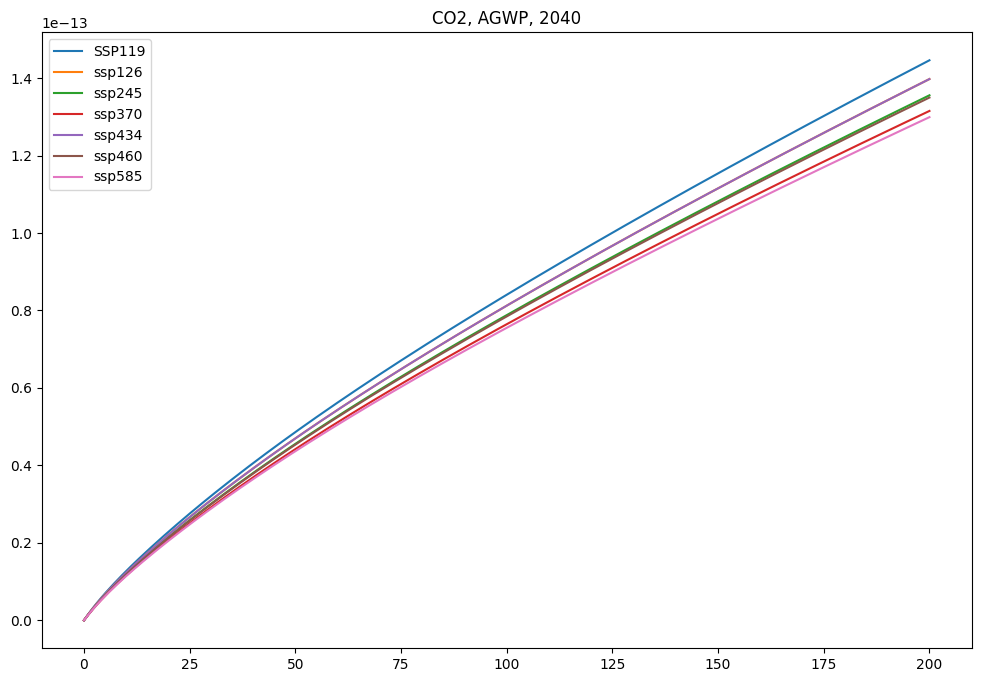

In [68]:
fdt = pd.DataFrame({"SSP119": agwp_co2_allssp_2040[0], 
                    "ssp126": agwp_co2_allssp_2040[1],
                    "ssp245": agwp_co2_allssp_2040[2],
                    "ssp370": agwp_co2_allssp_2040[3],
                    "ssp434": agwp_co2_allssp_2040[4],
                    "ssp460": agwp_co2_allssp_2040[5],
                    "ssp585": agwp_co2_allssp_2040[6]
                   })

fdt.plot(figsize=(12, 8),title = "CO2, AGWP, 2040")

<AxesSubplot:title={'center':'CH4, AGWP, 2040'}>

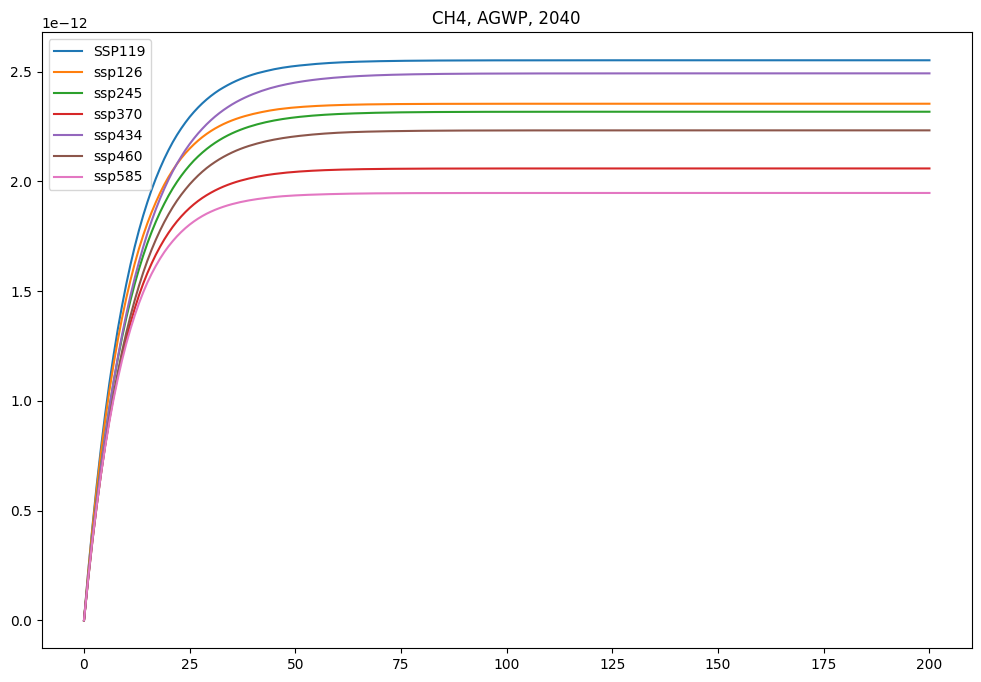

In [65]:
fdt1 = pd.DataFrame({"SSP119": agwp_ch4_allssp_2040[0], 
                    "ssp126": agwp_ch4_allssp_2040[1],
                    "ssp245": agwp_ch4_allssp_2040[2],
                    "ssp370": agwp_ch4_allssp_2040[3],
                    "ssp434": agwp_ch4_allssp_2040[4],
                    "ssp460": agwp_ch4_allssp_2040[5],
                    "ssp585": agwp_ch4_allssp_2040[6]
                   })

fdt1.plot(figsize=(12, 8), title = "CH4, AGWP, 2040")

<AxesSubplot:>

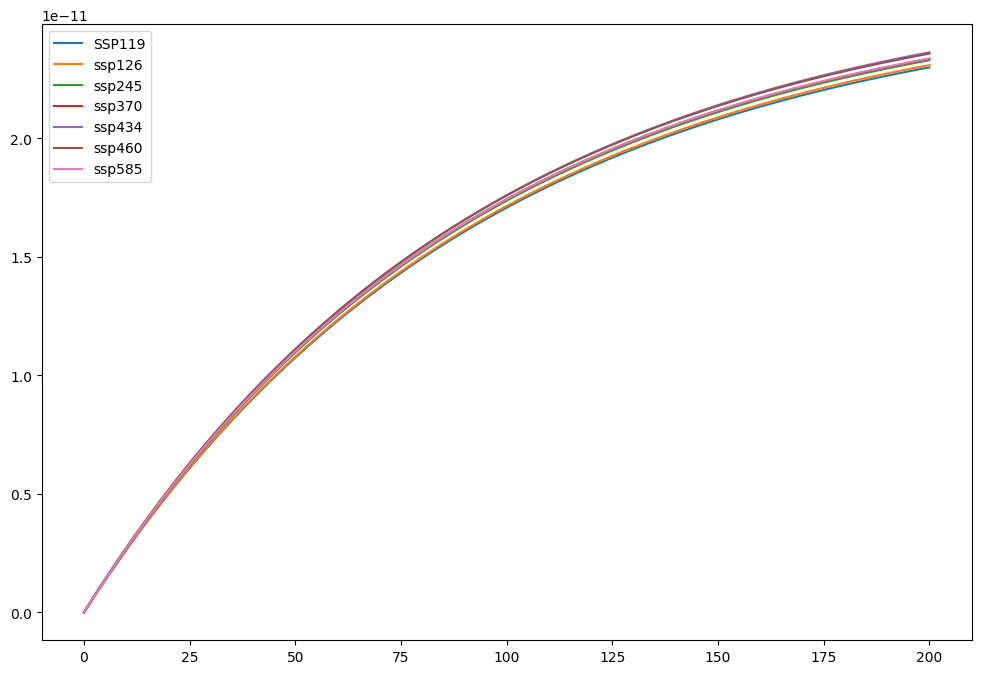

In [66]:
fdt2 = pd.DataFrame({"SSP119": agwp_n2o_allssp_2040[0], 
                    "ssp126": agwp_n2o_allssp_2040[1],
                    "ssp245": agwp_n2o_allssp_2040[2],
                    "ssp370": agwp_n2o_allssp_2040[3],
                    "ssp434": agwp_n2o_allssp_2040[4],
                    "ssp460": agwp_n2o_allssp_2040[5],
                    "ssp585": agwp_n2o_allssp_2040[6]
                   })

fdt2.plot(figsize=(12, 8))

In [67]:
fig = px.line(fdt, x =  np.arange(201), y=fdt.columns[0:], title='AGWP_CO2_2040')
fig.show()

In [28]:
# try saving f for further use, tried with SQLITE3 super slow, xr can save but can't open 
import xarray as xr
dtc = f.concentration 
dtc.to_netcdf('data/fair/output/concentration.nc')  #2.3GB
loaded_f_c = xr.open_dataset('./data/fair/output/concentration.nc')

AttributeError: 'EntryPoints' object has no attribute 'get'